In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from baseline_smc import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import datetime
import time 
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 2

## Model Parameters
num_particles = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * K
NUM_EPOCHS = 400
LEARNING_RATE = 1e-3
RESTORE = False
PATH_ENC = "baseline_smc/hao/baseline_2shots-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

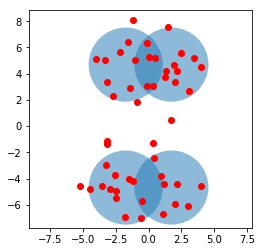

In [3]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [5]:
def initialize():
    enc_trans = Encoder()
    optimizer =  torch.optim.Adam(list(enc_trans.parameters()),lr=LEARNING_RATE)    
    return enc_trans, optimizer

enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    eubo, kl, ess, variational, elbo = oneshot_givenZ(enc, alpha_trans_0, Pi, mu_ks, cov_ks, A_true, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ELBOs.append(elbo.item())
    ESSs.append(ess)
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f, KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

# if RESTORE:
#     enc.load_state_dict(torch.load(PATH_ENC))
# else:
#     torch.save(enc.state_dict(), PATH_ENC)
#     save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -240.667572, elbo : -260.630310, KL : 48.324295 (4s)
epoch : 1, eubo : -267.662109, elbo : -300.984283, KL : 56.472660 (4s)
epoch : 2, eubo : -259.120605, elbo : -286.052612, KL : 49.835453 (4s)
epoch : 3, eubo : -229.226074, elbo : -258.445160, KL : 43.414085 (4s)
epoch : 4, eubo : -227.206116, elbo : -244.317261, KL : 45.290985 (4s)
epoch : 5, eubo : -248.002716, elbo : -275.905090, KL : 39.517338 (4s)
epoch : 6, eubo : -227.890396, elbo : -253.166855, KL : 43.834232 (4s)
epoch : 7, eubo : -264.207062, elbo : -287.213684, KL : 47.217426 (5s)
epoch : 8, eubo : -244.943512, elbo : -261.398224, KL : 45.708878 (4s)
epoch : 9, eubo : -243.623047, elbo : -258.263641, KL : 35.998775 (4s)
epoch : 10, eubo : -225.332565, elbo : -242.783752, KL : 45.569248 (4s)
epoch : 11, eubo : -247.810974, elbo : -270.159088, KL : 46.813374 (4s)
epoch : 12, eubo : -256.519318, elbo : -287.518677, KL : 46.496231 (4s)
epoch : 13, eubo : -223.698456, elbo : -236.322311, KL : 35.407261 (4s)
ep

In [7]:
plot_dirs(variational, alpha_trans_0, Z_true, T, K, vmax=15)

NameError: name 'Z_true' is not defined

In [8]:
plot_results(EUBOs, ELBOs, KLs, ESSs)

NameError: name 'ELBOs' is not defined

In [ ]:
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)